# _Generate Embedding Script Development_

This notebook is devoted towards developing a Python script that will generate and then store embeddings for each day of Tweets within our data set. 

In [2]:
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re
tqdm.pandas()

In [3]:
def path_to_data():
    return Path.cwd().parent.parent / 'data' / 'dailies'

In [4]:
data_path = path_to_data()

In [5]:
filename = '2020-06-24_tweets.parquet'


def normalize_token(token):
    lwrcase_tok = token.lower()
    if token.startswith('@'):
        return '@USER'
    elif lwrcase_tok.startswith('http') or lwrcase_tok.startswith('www'):
        return 'HTTPURL'
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalize_tweet(tweet):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalize_token(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    normTweet = re.sub(
        r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet
    )
    normTweet = re.sub(
        r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet
    )
    normTweet = re.sub(
        r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet
    )

    return " ".join(normTweet.split())


def clean_data(df):
    '''
    Given input dataframe, creates subset of only English 
    tweets, and applies text normalization according to
    normalize_tweet function above.
    '''
    # subset of English-only tweets
    df_english = df[df['lang'] == 'en'].reset_index(drop=True)
    
    # text normalization
    df_english['normalized_tweet'] = df_english['full_text'].apply(
        lambda tweet: normalize_tweet(tweet)
    )
    return df_english
    

def load_parquet_data(data_path, filename):
    '''
    Loads in file according to data_path and filename,
    applies necessary edits to return only English
    Tweets, and returns pandas dataframe
    '''
    # get folder name according to filename
    folder = filename.split('_')[0]
    
    # load in parquet file
    df = pd.read_parquet(
        f'{data_path}/{folder}/{filename}',
    )
    
    # apply necessary edits
    df = clean_data(df)
    
    return df

In [6]:
%%time
df = load_parquet_data(data_path, filename)

CPU times: user 1min 28s, sys: 2.51 s, total: 1min 31s
Wall time: 1min 30s


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444182 entries, 0 to 444181
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   created_at        444182 non-null  datetime64[ns, UTC]
 1   id_str            444182 non-null  object             
 2   user_id_str       444182 non-null  object             
 3   lang              444182 non-null  object             
 4   full_text         444182 non-null  object             
 5   normalized_tweet  444182 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 20.3+ MB


## _Generate Embeddings_

In [8]:
from sentence_transformers import SentenceTransformer


def create_embedding_model(embed_model_name):
    '''
    Given string of pretrain embedding available in sentence-transformers
    library, create a SentenceTransformer object to encode embeddings with
    '''
    model = SentenceTransformer(embed_model_name)
    return model

In [10]:
EMBED_MODEL_NAME = 'distilbert-base-nli-stsb-mean-tokens'

# create Sentence Transformer model from distilbert
model = create_embedding_model(EMBED_MODEL_NAME)

In [13]:
def generate_embeddings(model, tweets):
    '''
    Given a SentenceTransformer model object, and a tweets object,
    containing a pandas Series of tweets, use embedding model to
    encode tweets with model object.
    '''
    tweet_embeddings = model.encode(tweets, show_progress_bar=True)
    return tweet_embeddings

In [14]:
# for the purposes of speed & experimentation, we're only going to use the first 25K tweets
tweets = df['normalized_tweet']

In [15]:
%%time
tweet_embeddings = generate_embeddings(model, tweets)


CPU times: user 22h 18min 25s, sys: 4min 37s, total: 22h 23min 3s
Wall time: 3h 14min 40s


## _Generate Means to Store Embeddings w/ Associated Tweet IDs_

In [17]:
#!pip install "dask[complete]"

In [18]:
import dask.array as da

In [19]:
da.from_array(tweet_embeddings)

dask.array<array, shape=(444182, 768), dtype=float32, chunksize=(23378, 768), chunktype=numpy.ndarray>

In [20]:
# gather tweet IDs that are associated with first 1k tweets
tweet_ids = df['id_str']

def generate_embedding_df(tweet_ids, tweet_embeddings):
    '''
    Given a series of tweet IDs and a list of tweet_embeddings
    (where each observation in the list is an array containing the
    embeddings), combines the two to produce a pandas DataFrame
    '''
    df = pd.DataFrame(tweet_embeddings)
    
    # apply more appropriate column names
    old_cols = df.columns.values
    new_cols = ['embed_' + str(x + 1) for x in old_cols]
    df.columns = new_cols
    
    # insert tweet IDs series as first column
    df.insert(loc=0, column='tweet_id', value=tweet_ids)
    
    return df

In [21]:
%%time
embeddings_df = generate_embedding_df(tweet_ids, tweet_embeddings)

CPU times: user 3min 33s, sys: 12.7 s, total: 3min 46s
Wall time: 3min 46s


In [22]:
embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444182 entries, 0 to 444181
Columns: 769 entries, tweet_id to embed_768
dtypes: float64(768), object(1)
memory usage: 2.5+ GB


In [23]:
%%time
folder_date = filename.split('_')[0]

data_path = path_to_data()

embeddings_df.to_parquet(
    f'{data_path}/{folder_date}/{folder_date}_embeddings.parquet'
)

CPU times: user 30.8 s, sys: 4.53 s, total: 35.4 s
Wall time: 32.9 s


## _Generate UMAP version of `embeddings_df`_

In [24]:
#import cudf
#import cuml

In [25]:
#!pip install umap-learn
#!pip install umap-learn[plot]
#!pip install bokeh --upgrade

In [26]:
import umap

def generate_umap_embeddings(embeddings_df):
    '''
    Given a pandas dataframe of embeddings (with first column
    representing a respective tweet ID), apply UMAP to reduce
    dimensionality to 2, to create representation of data that
    can then be visualized in 2D space.
    '''
    # gather only embedding values (i.e. drop column with IDs)
    embedding_data = embeddings_df.iloc[:, 1:].values
    
    # init umap object and apply to embedding data
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.01,
        spread=0.25,
        metric='cosine',
        random_state=8,
        transform_seed=8
    )
    umap_embeddings = reducer.fit_transform(
        embedding_data
    )
    
    # create pandas dataframe from embeddings, with IDs as first column
    umap_embeddings_df = pd.DataFrame(
        umap_embeddings, columns=('x', 'y')
    )
    umap_embeddings_df.insert(
        loc=0, column='tweet_id', value=embeddings_df['tweet_id']
    )
    
    return umap_embeddings_df

In [ ]:
%%time
umap_embeddings_df = generate_umap_embeddings(embeddings_df)

/opt/conda/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [24]:
umap_embeddings_df

,tweet_id,x,y
0,1275579785079472129,4.370631,5.278501
1,1275579785842814976,4.369429,4.624718
2,1275579786434232320,4.265803,3.562437
3,1275579786618793984,2.774232,2.908997
4,1275579789538033665,4.750591,4.784646
...,...,...,...
24995,1275600133254721537,4.180532,5.407028
24996,1275600133636284416,4.273987,4.912381
24997,1275600135112753155,4.380994,5.051008
24998,1275600136366895113,4.371548,4.605233


In [25]:
import umap.plot
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

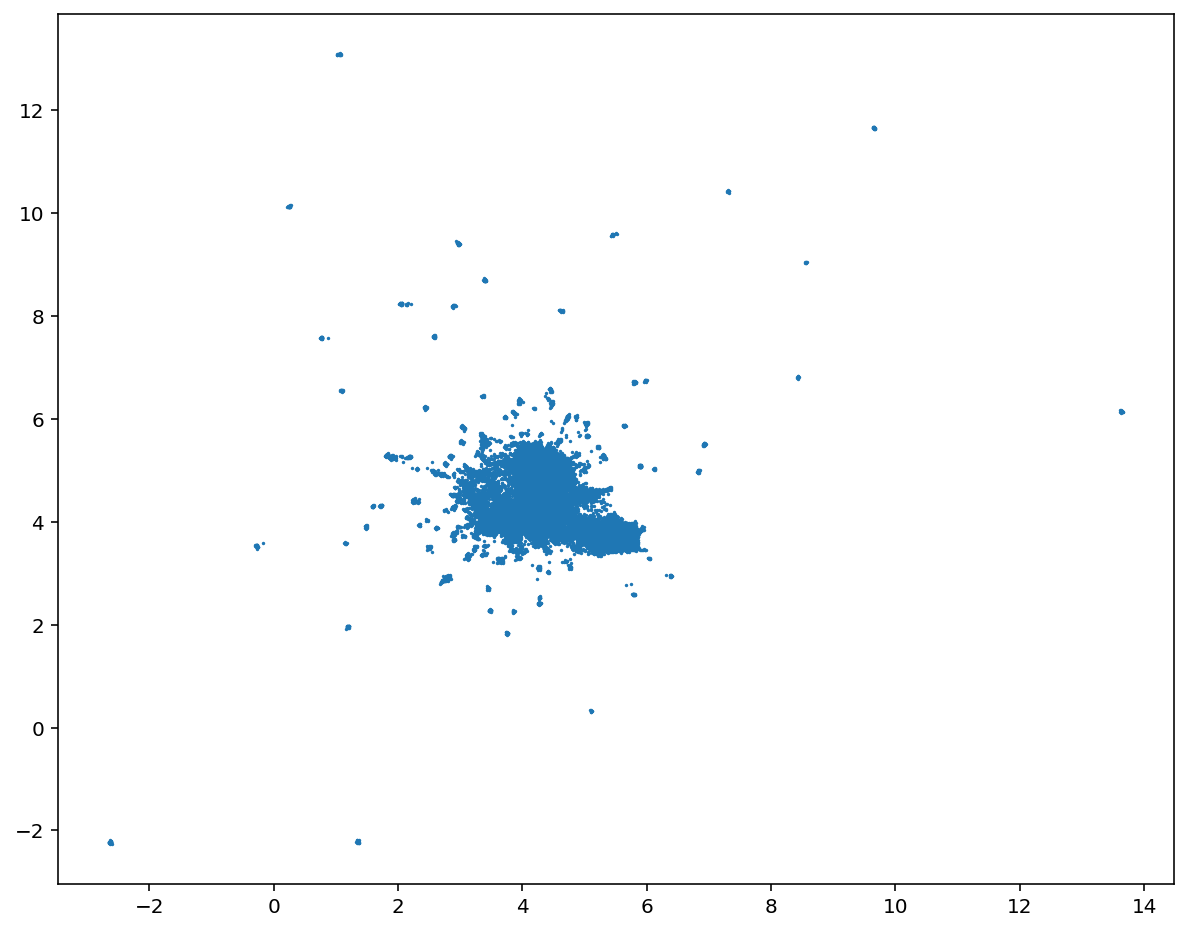

In [26]:
plt.figure(figsize=(10,8))

plt.scatter(
    umap_embeddings_df['x'],
    umap_embeddings_df['y'],
    s=0.5
);

## _Save Embeddings & UMAP Embeddings_

In [135]:
def save_embeddings(filename, embeddings_df, umap_embeddings_df):
    '''
    Given a filename, and two pandas dataframe, one of all the 
    embeddings, and of the UMAP embeddings (reduced to 2D), 
    then save the files in same location where parquet file was 
    stored.
    '''
    # get folder name according to filename (i.e. the date)
    folder_date = filename.split('_')[0]
    # retrieve path to data
    data_path = path_to_data()
    
    # save both embedding dataframes
    embeddings_df.to_parquet(
        f'{data_path}/{folder_date}/{folder_date}_embeddings.parquet',
    )
    umap_embeddings_df.to_parquet(
        f'{data_path}/{folder_date}/{folder_date}_umap_embeds.parquet'
    )

In [136]:
save_embeddings(filename, embeddings_df, umap_embeddings_df)

## _Sanity check_

In [137]:
test1 = pd.read_parquet(
    f'{path_to_data()}/2020-06-24/2020-06-24_embeddings.parquet'
)

In [139]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 769 entries, tweet_id to embed_768
dtypes: float64(768), object(1)
memory usage: 5.9+ MB


In [140]:
test2 = pd.read_parquet(
    f'{path_to_data()}/2020-06-24/2020-06-24_umap_embeds.parquet'
)

In [141]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1000 non-null   object 
 1   x         1000 non-null   float32
 2   y         1000 non-null   float32
dtypes: float32(2), object(1)
memory usage: 15.8+ KB
